<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/cv/cv-uis-student/raw/master/imgs/logo_CV.jpeg" style="width:1500px;heigth:100px">


# <center> 05. Motion Characterization: Optical flow algorithm</center>

## <span style="color:red"> Outline </span> 
1. **Modelling motion: Optical flow principles**
2. **Lukas Kannade approach**
3. **Descriptors based on flow**


In [2]:
import cv2 as cv
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

## <span style="color:green"> If you are in colaboratoy </span>: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My Drive/cv-uis-student/notebooks
!pwd

**Remeber: motion is fundamental for visual systems**...we can recover structure from a very sparse set of points, using coherency of **motion!**

<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/cv/cv-uis-student/raw/master/imgs/motion1.gif" style="width:200px"> <img src="https://gitlab.com/bivl2ab/academico/cursos-uis/cv/cv-uis-student/raw/master/imgs/motion2.gif" style="width:200px">

Start by loading the video-sequences

In [3]:
Video_1 = cv.VideoCapture("../data/long_videos/street.avi")
frames_V1 = [cv.cvtColor(Video_1.read()[1], cv.COLOR_BGR2RGB) 
             for _ in range(2,int(Video_1.get(cv.CAP_PROP_FRAME_COUNT)))]

Video_2 = cv.VideoCapture("../data/video_set_UT/29_5_5.avi")
frames_V2 = [cv.cvtColor(Video_2.read()[1], cv.COLOR_BGR2RGB) for _ in range(2,int(Video_2.get(cv.CAP_PROP_FRAME_COUNT)))]


In [4]:
interact(lambda index:plt.imshow(frames_V1[index]), 
         index = widgets.IntSlider(min=0,max=(len(frames_V1)-1),
                                   step=1,value=0));

interactive(children=(IntSlider(value=0, description='index', max=117), Output()), _dom_classes=('widget-inter…

## <span style="color:red"> 1. Modelling motion: Optical flow principles </span> 

<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/cv/cv-uis-student/raw/master/imgs/taxi.gif" style="width:300px">
<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/cv/cv-uis-student/raw/master/imgs/taxi_cmap.gif" style="width:300px">
<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/cv/cv-uis-student/raw/master/imgs/tennis.png" style="width:300px">



Represent the **apparent movement** of objects into a scene. Through optical flow we can estimate the motion direction and velocity of each point in a sequence of images.

### **More important ASSUMPTIONS**

<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/cv/cv-uis-student/raw/master/imgs/of1.png" style="width:500px">

How do we estimate pixel motion among consecutive frames?

R:/ the solution is about correspondence of objects. But regarding some assumptions.


- **Brightness constancy:** projection of the same point looks the same in every frame
- **Small motion:** points do not move very far
- **Spatial coherence:** points move like their neighbors

So, We can model motion as (**Brightness constancy assumption**): 

$$\underbrace{I(x,y,t)}_{A} = \underbrace{I(x+\Delta_x, y + \Delta_y, t+\Delta_t)}_{B}$$

Also, we can express $B$ as a taylor serie (**Small motion assumption**), as:

$$I(x+\Delta_x, y + \Delta_y, t+\Delta_t) = I(x,y,t) + \frac{\partial I \Delta x}{\partial x} + \frac{\partial I \Delta y}{\partial y} 
+ \frac{\partial I \Delta t}{\partial t}$$

To satisfy the equality, we have: 

$$
\frac{\partial I \Delta x}{\partial x} + \frac{\partial I \Delta y}{\partial y} 
+ \frac{\partial I \Delta t}{\partial t} = 0
$$

Normalizing, last equation w.r.t $\Delta_t$, we can write: 


$$
\frac{\partial I \Delta x}{\partial x  \Delta t } + \frac{\partial I \Delta y}{\partial y  \Delta t} 
+ \frac{\partial I }{\partial t} = 0
$$


So, we can define: 

- $\frac{\Delta x}{\Delta t} = V_x$, the displacement of $x$ with respecto to the time $t$
- $\frac{\Delta y}{\Delta t} = V_y$, the displacement of $y$ with respecto to the time $t$

We can re-write the equation, as follows: 

$$I_{x}V_{x} + I_{y}V_{y} + I_t =0$$, 
$$I_{x}V_{x} + I_{y}V_{y} =- I_t$$

**How many unknowns and equations ?:**. Here we have two unknows and 1 equation, so it is undetermined. 

If we can write on matricial notation, we can write as $Ax=-b$, so we have: 

$$
\underbrace{
\begin{bmatrix}
I_x(p_1) & I_y(p_1) \\ 
I_x(p_2) & I_y(p_2)\\ 
I_x(p_3) & I_y(p_3)\\ 
\vdots  & \vdots \\ 
I_x(p_n) & I_y(p_n)
\end{bmatrix}
}_{A}
\underbrace{
\begin{bmatrix}
V_x\\ 
V_y
\end{bmatrix}
}_{x} = -
\underbrace{
\begin{bmatrix}
I_t(p_1)  \\ 
I_t(p_2) \\ 
I_t(p_3)\\ 
\vdots   \\ 
I_t(p_n)
\end{bmatrix}
}_{b}
$$

- A system with more equations than unknowns!

- This is the analysis over a windows with $n$ pixels (**spatial coherency assumption**)
#### <span style="color:red"> Resulting in a Overdetermined system! </span> 



#### <span style="color:blue"> The aperture problem! </span> 


So me need more local constrains: 
<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/cv/cv-uis-student/raw/master/imgs/aperture.gif" style="width:300px">

To major illustration, please visit [Example](http://elvers.us/perception/aperture/)

- The pixel's neighbors have the same $(u,v)$

#### <span style="color:red"> How can we solved it? </span> 
## <span style="color:red"> 2. A Lukas Kannade approximation </span> 

The method of **ordinary least squares** can be used to approximate the system ${\displaystyle Ax=b,}$ as: 

$$\min_{x}||Ax -b||$$

**We assume that locally the motion field is very smooth**. So, we can write the system, as: 
$$Ax=b$$
$$(A^{{{\mathrm  {T}}}}A)x = A^{T}b$$
$$x=(A^{{{\mathrm  {T}}}}A)^{{-1}}A^{{{\mathrm  {T}}}}b$$

Then, the system could be writted: 

$$
\begin{bmatrix}
Vx \\ Vy
\end{bmatrix}
= 
\begin{bmatrix}
\sum_{i}I_{x}(p_i)^{2}  & \sum_i I_{x}(p_i)I_{y}(p_i) \\ 
\sum_i I_{y}(p_i)I_{x}(p_i) & \sum_{i}I_{y}(p_i)^{2} 
\end{bmatrix}^{-1}
\begin{bmatrix}
-\sum_i I_{x}(p_i)I_t(pi)\\ 
-\sum_i I_{y}(p_i)I_t(pi)
\end{bmatrix}
$$

- $A^{T}A$ should be well-conditioned ($\lambda_1/\lambda_2$)

**Go to the action!**

In [4]:

import numpy as np
from scipy import signal
#code from [2]

def optical_flow(I1g, I2g, window_size, tau=1e-2):
 
    kernel_x = np.array([[-1., 1.], [-1., 1.]])
    kernel_y = np.array([[-1., -1.], [1., 1.]])
    kernel_t = np.array([[1., 1.], [1., 1.]])#*.25
    w = window_size/2 # window_size is odd, all the pixels with offset in between [-w, w] are inside the window
    I1g = I1g / 255. # normalize pixels
    I2g = I2g / 255. # normalize pixels
    # Implement Lucas Kanade
    # for each point, calculate I_x, I_y, I_t
    mode = 'same'
    fx = signal.convolve2d(I1g, kernel_x, boundary='symm', mode=mode)
    fy = signal.convolve2d(I1g, kernel_y, boundary='symm', mode=mode)
    ft = signal.convolve2d(I2g, kernel_t, boundary='symm', mode=mode) + signal.convolve2d(I1g, -kernel_t, boundary='symm', mode=mode)
    u = np.zeros(I1g.shape)
    v = np.zeros(I1g.shape)
    # within window window_size * window_size
    for i in range(w, I1g.shape[0]-w):
        for j in range(w, I1g.shape[1]-w):
            Ix = fx[i-w:i+w+1, j-w:j+w+1].flatten()
            Iy = fy[i-w:i+w+1, j-w:j+w+1].flatten()
            It = ft[i-w:i+w+1, j-w:j+w+1].flatten()
            b = np.reshape(It, (It.shape[0],1))  # get b here
            A =  np.vstack((Ix, Iy)).T  # get A here
            # if threshold τ is larger than the smallest eigenvalue of A'A:
            if np.min(abs(np.linalg.eigvals(np.matmul(A.T, A)))) >= tau:
                nu = np.matmul(np.linalg.pinv(A), b)
                u[i,j]=nu[0]
                v[i,j]=nu[1]
 
    return (u,v)


In [5]:
I3g = cv.cvtColor(frames_V1[70], cv.COLOR_RGB2GRAY)
I4g = cv.cvtColor(frames_V1[71], cv.COLOR_RGB2GRAY)


u2, v2 = optical_flow(I3g, I4g, window_size=10, tau=1e-2)

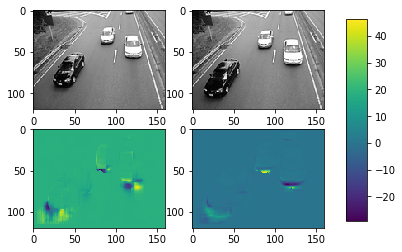

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=2);
l = [ax for ax in axes.flat]
im = l[0].imshow(I3g, interpolation="nearest", cmap='gray')
im = l[1].imshow(I4g, interpolation="nearest", cmap='gray')
im = l[2].imshow(u2, interpolation="nearest")
im = l[3].imshow(v2, interpolation="nearest")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax);

## <span style="color:orange">student challenge</span>: 

For a couple of frames: 
- From $(u,v)$ compute the magnitude and angle of the optical flow

## <span style="color:orange">student challenge</span>: 

For a couple of frames: 
- use the function `quiver` to represent the vector field corresponding among couple of frames.

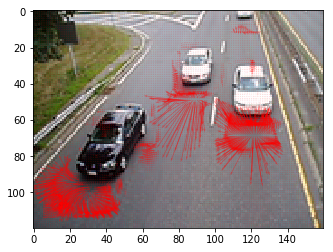

In [13]:
print u2[::2,::2].shape
print u2.shape

(60, 80)
(120, 160)


## <span style="color:orange">student challenge</span>: 

1. Visualize the video of the component $u_t$ along the sequence
2. Visualize the video of the component $v_t$ along the sequence
3. Visualize the resulting video with quiver function

**Some limitations**

- Assumption that motion is small...in much of the sequences the motion is large because dynamic of the object, because camera resolution (large displacement). Taylor doesn't hold
- In fact each of the assumptions should be analized on the evalauted sequences. 

## <span style="color:red"> 3. Descriptors based on optical flow </span> 

## <span style="color:orange">student challenge</span>: 

- How to obtain a better representation of the optical flow?
- How to compute a descriptor from computed optical flor to describe particular action. **TO DO ACTION RECOGNITION**




# References

[1] B. Lucas and T. Kanade. An iterative image registration technique with an application to
stereo vision. In Proceedings of the International Joint Conference on Artificial Intelligence, pp.
674–679, 1981.

[2 Implementation LK](https://sandipanweb.wordpress.com/2018/02/25/implementing-lucas-kanade-optical-flow-algorithm-in-python/)

<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/cv/cv-uis-student/raw/master/imgs/bannerThanks.jpg" style="width:1000px;">